In [0]:

from urllib.request import urlretrieve
import os
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from zipfile import ZipFile



In [2]:
def download(url, file):
    
    urlretrieve(url, file)
    print('retireved')
    
download('https://behaviourcloning1.s3.us-east-2.amazonaws.com/data.zip','data.zip')



retireved


In [3]:
def uncompress(dir):
  
  with ZipFile(dir) as zipf:
    zipf.extractall('data')
    print('extracted')
    
uncompress('data.zip')

extracted


In [4]:
os.listdir('data/data')

['IMG', 'out.csv']

In [5]:
import csv
import pandas as pd

os.chdir('data')
df = pd.read_csv('./data/out.csv')
df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [6]:
sets = df.values.tolist()

print(sets[:5])


[['IMG/center_2016_12_01_13_30_48_287.jpg', ' IMG/left_2016_12_01_13_30_48_287.jpg', ' IMG/right_2016_12_01_13_30_48_287.jpg', 0.0, 0.0, 0.0, 22.14829], ['IMG/center_2016_12_01_13_30_48_404.jpg', ' IMG/left_2016_12_01_13_30_48_404.jpg', ' IMG/right_2016_12_01_13_30_48_404.jpg', 0.0, 0.0, 0.0, 21.87963], ['IMG/center_2016_12_01_13_31_12_937.jpg', ' IMG/left_2016_12_01_13_31_12_937.jpg', ' IMG/right_2016_12_01_13_31_12_937.jpg', 0.0, 0.0, 0.0, 1.453011], ['IMG/center_2016_12_01_13_31_13_037.jpg', ' IMG/left_2016_12_01_13_31_13_037.jpg', ' IMG/right_2016_12_01_13_31_13_037.jpg', 0.0, 0.0, 0.0, 1.4384190000000001], ['IMG/center_2016_12_01_13_31_13_177.jpg', ' IMG/left_2016_12_01_13_31_13_177.jpg', ' IMG/right_2016_12_01_13_31_13_177.jpg', 0.0, 0.0, 0.0, 1.418236]]


In [7]:
print(df[:5])

                                   center  ...      speed
0  IMG/center_2016_12_01_13_30_48_287.jpg  ...  22.148290
1  IMG/center_2016_12_01_13_30_48_404.jpg  ...  21.879630
2  IMG/center_2016_12_01_13_31_12_937.jpg  ...   1.453011
3  IMG/center_2016_12_01_13_31_13_037.jpg  ...   1.438419
4  IMG/center_2016_12_01_13_31_13_177.jpg  ...   1.418236

[5 rows x 7 columns]


In [0]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

train_set, validation_set = train_test_split(sets , test_size = 0.2)

In [0]:
import cv2
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from skimage import exposure, img_as_ubyte
from skimage.util import random_noise

def generator(sets, batch = 64):
  
  len_sets = len(sets)
  
  while 1:
    shuffle(sets)
    
    for offset in range(0, len_sets , batch):
      
      batch_sets = sets[offset:offset+batch]
      
      images = []
      angles = []
      
      for line in batch_sets: 
        
        for i in range(0,3): #to get centre, left and right images
          
          name = './data/IMG/' + line[i].split('/')[-1]
          
          centre_image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
          
          centre_angle = float(line[3])
          
          images.append(centre_image)
          
          if(i == 0):
            angles.append(centre_angle)
          elif(i == 1):
            angles.append(centre_angle + 0.2)
          elif (i== 2):
            angles.append(centre_angle - 0.2)
            
          images.append(cv2.flip(centre_image,1))
          
          if(i==0):
            angles.append(centre_angle * -1)
          elif(i == 1):
            angles.append((centre_angle + 0.2) * -1)
          elif(i == 2):
            angles.append((centre_angle - 0.2) * -1)
            
          
          aug_img = cv2.cvtColor(centre_image,cv2.COLOR_RGB2HSV)  #randomising brighness value
          brightness = .25 + np.random.uniform()
          aug_img[::2] =  aug_img[::2] * brightness
          aug_img = cv2.cvtColor(aug_img, cv2.COLOR_HSV2RGB)
          
          images.append(aug_img)
          
          if(i == 0):
            angles.append(centre_angle)
          elif(i == 1):
            angles.append(centre_angle + 0.2)
          elif (i== 2):
            angles.append(centre_angle - 0.2)
          
          aug_img_eq = np.copy(centre_image)
          for channel in range(aug_img_eq.shape[2]):
            aug_img_eq[:,:, channel] = exposure.equalize_hist(aug_img_eq[:,:, channel])* 255
            
          images.append(aug_img_eq)
          
          if(i==0):
            angles.append(centre_angle * -1)
          elif(i == 1):
            angles.append((centre_angle + 0.2) * -1)
          elif(i == 2):
            angles.append((centre_angle - 0.2) * -1)
          
          
          aug_img_noise = img_as_ubyte(random_noise(centre_image, mode = 'gaussian'))
          
          images.append(aug_img_noise)
          
          if(i==0):
            angles.append(centre_angle * -1)
          elif(i == 1):
            angles.append((centre_angle + 0.2) * -1)
          elif(i == 2):
            angles.append((centre_angle - 0.2) * -1)    
          
           
      X_train = np.array(images)
      y_train = np.array(angles)
      
      yield sklearn.utils.shuffle(X_train,y_train)
      
      
train_generator = generator(train_set, batch = 8)
validation_generator = generator(validation_set, batch = 8)
          
          
          
        

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers import Lambda, Cropping2D

model = Sequential()

#normalizing the images and mean centering
model.add(Lambda(lambda x: (x/ 255.0) - 0.5 ,input_shape = (160,320,3)))
#cropping the images while passing into the model(selecting required part of image)
model.add(Cropping2D(cropping = ((70,25),(0,0))))

model.add(Convolution2D(24,5,5,subsample = (2,2)))
model.add(Activation('elu'))

model.add(Convolution2D(36,5,5,subsample = (2,2)))
model.add(Activation('elu'))

model.add(Convolution2D(48,5,5,subsample = (2,2)))
model.add(Activation('elu'))

model.add(Convolution2D(64,3,3))
model.add(Activation('elu'))

model.add(Convolution2D(64,3,3))
model.add(Activation('elu'))

model.add(Flatten())

model.add(Dense(100))
model.add(Activation('elu'))

model.add(Dropout(0.25))

model.add(Dense(50))
model.add(Activation('elu'))

model.add(Dense(10))
model.add(Activation('elu'))

model.add(Dense(1))

model.compile(loss = 'mse', optimizer = 'adam')

model.fit_generator(train_generator,samples_per_epoch = len(train_set),validation_data = validation_generator, nb_val_samples = len(validation_set),nb_epoch = 5, verbose = 1)

model.summary()
model.save('model.h5')

print('Model Saved!')









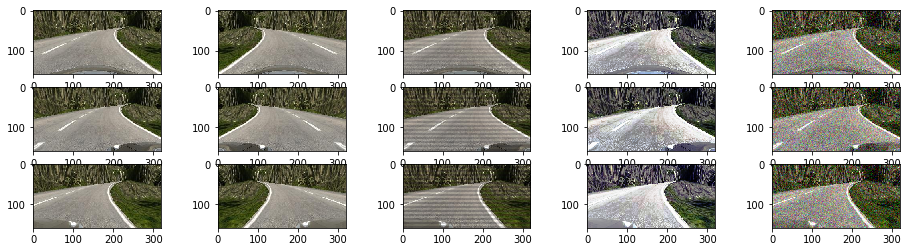

In [25]:
import matplotlib.pyplot as plt



f, ax = plt.subplots(3, 5, figsize=(16, 4))

for idx, img in enumerate(images[:14]):
  ax[idx//5, idx%5].imshow(img)
  
  
